In [1]:
%%capture
%pip install -r requirements.txt

In [2]:
import pyvista as pv
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
import logging
import pint
from scipy.constants import mu_0 as _mu_0
from scipy.special import iv, jv # Modified Bessel function of the first kind

Q = pint.UnitRegistry()
Q.setup_matplotlib()



logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
pv.set_jupyter_backend('static') 

In [3]:
_mu_0

1.25663706212e-06

In [4]:
RESOLUTION=100


In [5]:
diameter = 4e-3 * Q.meter
conductivity = 37e6 * Q.siemens / Q.meter
resistivity = 1 / conductivity
frequency = 50e3 * Q.Hz

resistance = 1 / (conductivity * np.pi * diameter**2 / 4)
resistance.to(Q.ohm/Q.meter)

omega = (frequency * 2 * np.pi).to(Q.rad/Q.second)
stepsPerPeriod = 100
periods = 1
nsteps = periods*stepsPerPeriod

MU_0 = _mu_0 * Q.henry / Q.meter
mu_r = 1
mu = mu_r * MU_0

dt = (1/(nsteps * frequency)).to(Q.second)
dt


<Quantity(2e-07, 'second')>

In [6]:
mu

<Quantity(1.25663706e-06, 'henry / meter')>

In [7]:
vtu_files = [f  for f in os.listdir(os.path.join(os.curdir,'results')) if f.endswith('.vtu')]
vtu_files.sort()
print(f'{len(vtu_files)} vtu files found')

101 vtu files found


In [8]:
mesh_t0 = pv.read(os.path.join(os.curdir,'results', vtu_files[0]))

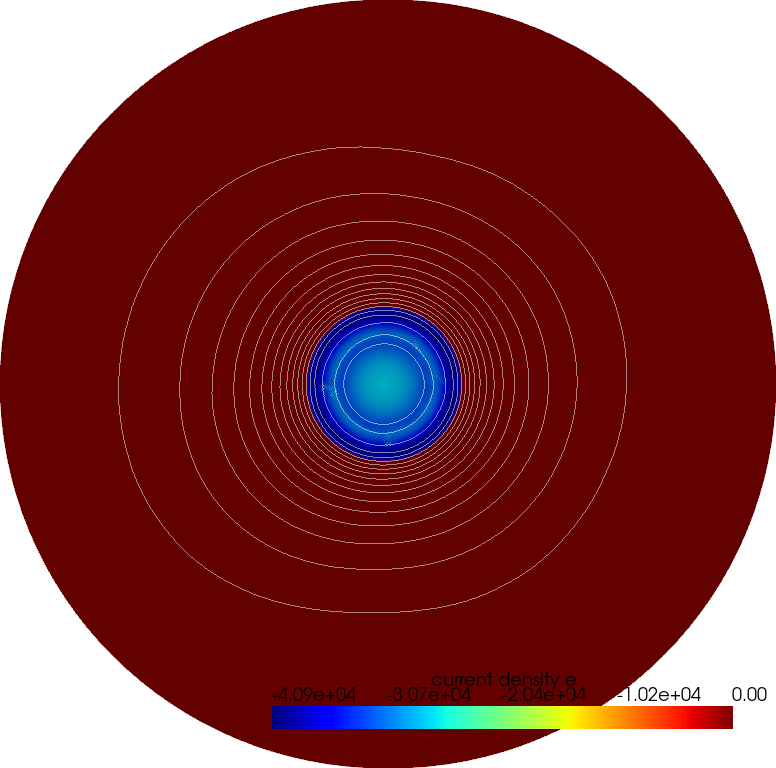

In [9]:
p = pv.Plotter(notebook=True)
p.add_mesh(mesh_t0, scalars="current density e", component=2, show_edges=False, cmap='jet')
p.add_mesh(mesh_t0.contour(isosurfaces=20, scalars='a', method='contour'),color='white',point_size=1, show_edges=False, opacity=0.5)
p.set_viewup([0,1,0])
p.camera.zoom('tight')
p.show()

In [10]:
WIRE_1_ID = 1
WIRE_2_ID = 2

wire_1 = mesh_t0.threshold([WIRE_1_ID - 0.1, WIRE_1_ID + 0.1], scalars="GeometryIds")

In [11]:
diameter.to_base_units().m

0.004

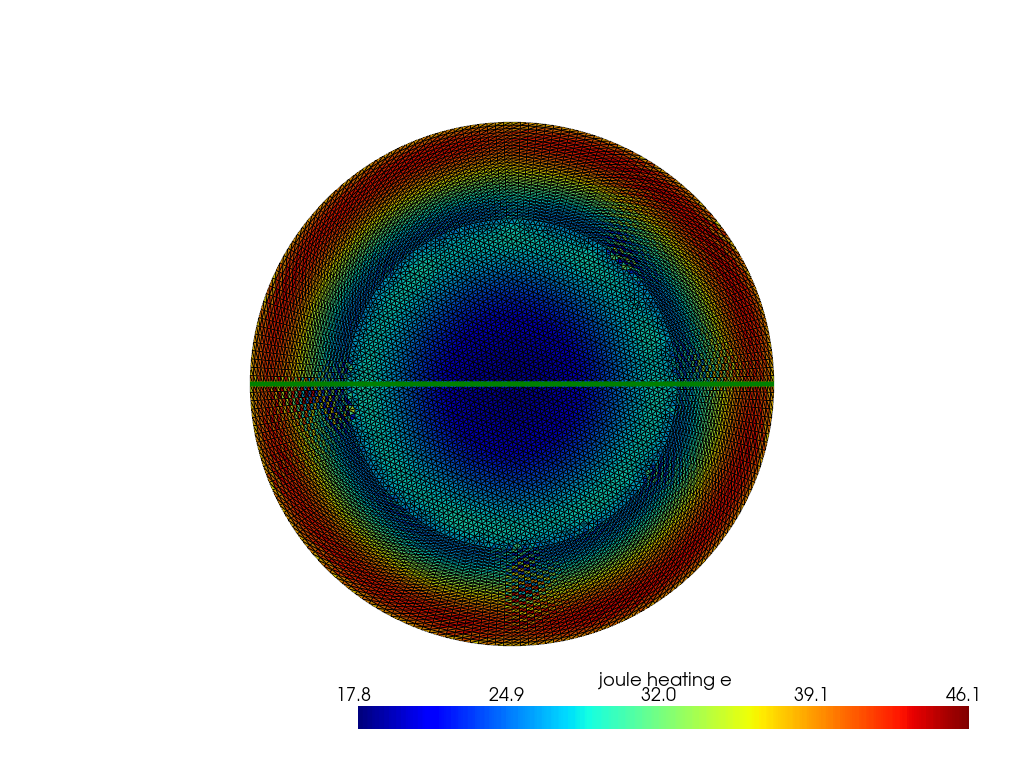

In [12]:
p = pv.Plotter(shape=(1, 1))
p.subplot(0, 0)
p.add_mesh(wire_1, scalars="joule heating e", component=2, show_edges=True, cmap='jet')
#p.update_scalar_bar_range([-200e3, 0])
p.set_viewup([0, 1, 0])
p.add_mesh(pv.Line((-diameter.to_base_units().m/2, 0, 0), (diameter.to_base_units().m/2, 0, 0)), color='green', line_width=5)

# p.subplot(0, 1)

# p.add_mesh(wire_1, scalars="joule heating e", show_edges=True, cmap='jet')
# p.set_viewup([0,1,0])
p.show()

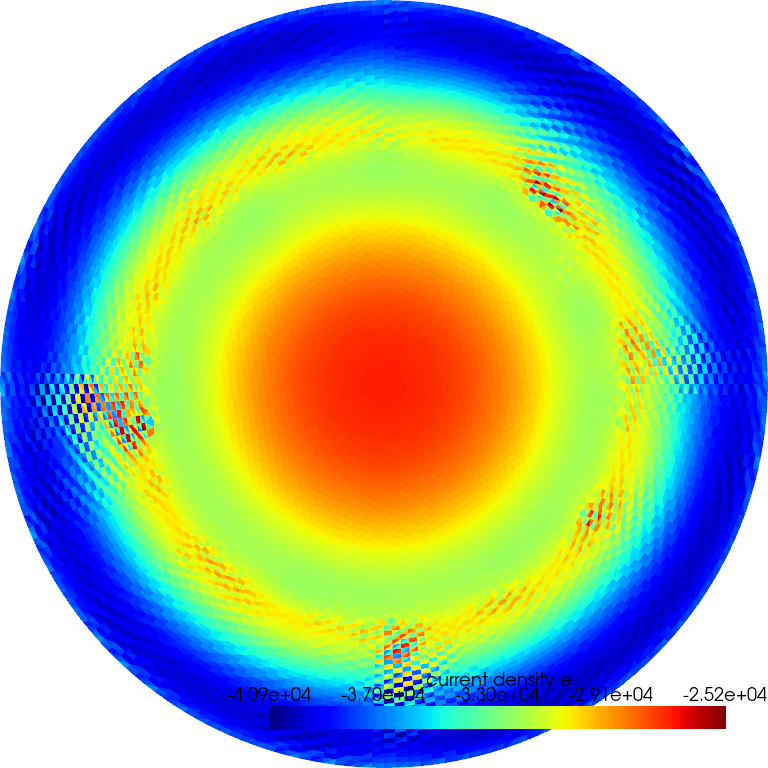

/Users/martinwest/Repositories/elmer-elmag/.venv/lib/python3.12/site-packages/pint/facets/numpy/numpy_func.py:322: RuntimeWarning: invalid value encountered in multiply
  result_magnitude = func(*stripped_args, **stripped_kwargs)
/Users/martinwest/Repositories/elmer-elmag/.venv/lib/python3.12/site-packages/pyvista/plotting/plotter.py:4872: PyVistaDeprecationWarning: This method is deprecated and will be removed in a future version of PyVista. Directly modify the points of a mesh in-place instead.
  warnings.warn(
/Users/martinwest/Repositories/elmer-elmag/.venv/lib/python3.12/site-packages/pyvista/plotting/plotter.py:4796: PyVistaDeprecationWarning: This method is deprecated and will be removed in a future version of PyVista. Directly modify the scalars of a mesh in-place instead.
  warnings.warn(


In [13]:


p = pv.Plotter(notebook=True, off_screen=True)
p.open_gif('results/j.gif')

mesh = pv.read(os.path.join(os.curdir,'results', vtu_files[0]))
wire_mesh = mesh.threshold([WIRE_1_ID - 0.1, WIRE_1_ID + 0.1], scalars="GeometryIds")
p.add_mesh(wire_mesh, scalars="current density e", component=2, show_edges=False, cmap='jet', lighting=False)
p.set_viewup([0,1,0])
p.camera.zoom('tight')
p.show()
p.update_scalar_bar_range([-4e5, 4e5])

wire_currrent = np.empty((len(vtu_files), 2)) * Q.A
wire_joule_heating = np.empty((len(vtu_files), 2)) * Q.W / Q.m
wire_current_density = np.empty((len(vtu_files), RESOLUTION+1)) * Q.A / Q.m**2
wire_positions = np.linspace(-diameter/2, diameter/2, RESOLUTION+1)

for idx, vtu_file in enumerate(vtu_files):
    mesh = pv.read(os.path.join(os.curdir,'results', vtu_file))
    for wire in [WIRE_1_ID, WIRE_2_ID]:
        wire_mesh = mesh.threshold([wire - 0.1, wire + 0.1], scalars="GeometryIds")
        wire_mesh_int = wire_mesh.integrate_data()
        wire_currrent[idx, wire - 1] = wire_mesh_int['current density e'][0, 2] * Q.A # 2 is the z component
        wire_joule_heating[idx, wire - 1] = wire_mesh_int['joule heating e'][0] * Q.W / Q.m
        # sample across the wire,
        if wire == WIRE_1_ID:
            p.update_coordinates(wire_mesh.points, render=False)
            p.update_scalars(wire_mesh['current density e'][:,2], render=False)
            p.write_frame()
            line_sample = wire_mesh.sample_over_line((-diameter.to_base_units().m/2,0,0),
                                                     ( diameter.to_base_units().m/2,0,0), resolution=RESOLUTION)
            wire_current_density[idx] = line_sample['current density e'][:,2] * Q.A / Q.m**2
p.close()

In [14]:
delta = np.sqrt((2 * resistivity)/((2*np.pi*frequency).to(Q.rad/Q.s) * mu))
delta.to(Q.mm)

<Quantity(0.370027726, 'millimeter')>

In [15]:
mu / (4e-7 *np.pi)

<Quantity(1.0, 'henry / meter')>

In [16]:
 
def J(r, i, diameter, resistivity, frequency, mu):
    omega = (frequency * 2 * np.pi).to(Q.rad/Q.s)
    delta = np.sqrt((2 * resistivity)/(omega * mu))
    delta.ito(Q.m)
    diameter.ito(Q.m)
    i.ito(Q.A)
    r.ito(Q.m)
    k = (1 - 1j) / delta.m
    j_r = ((k * i.m)/(2 * np.pi * (diameter/2).m)) * (jv(0, (k*r).m) / jv(1, (k*(diameter/2)).m))
    return j_r

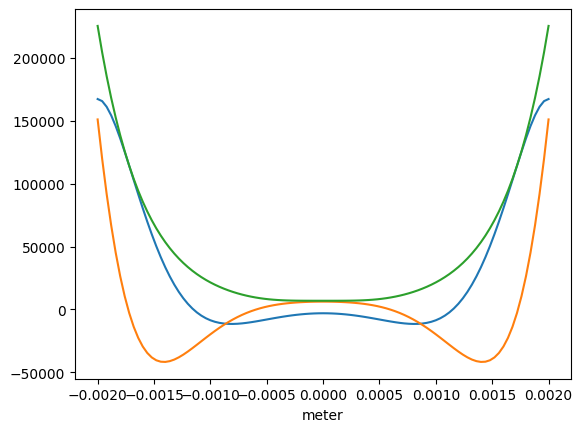

In [17]:
j = J(wire_positions, 1/np.sqrt(2) * Q.A, diameter, resistivity, frequency, mu)

plt.plot(wire_positions, j.real, label='Analytical')
plt.plot(wire_positions, j.imag, label='Analytical')
plt.plot(wire_positions, np.abs(j), label='Analytical')

In [18]:
1/np.sqrt(2) * Q.A / (np.pi * (diameter/2)**2).to(Q.m**2)

<Quantity(56269.7698, 'ampere / meter ** 2')>

In [19]:
r = (1 + 1j) * diameter.to(Q.m) / delta
f_skin = 0.5 * (r.to_base_units().magnitude * iv(0, r.to_base_units().magnitude) / iv(1, r.to_base_units().magnitude)).real

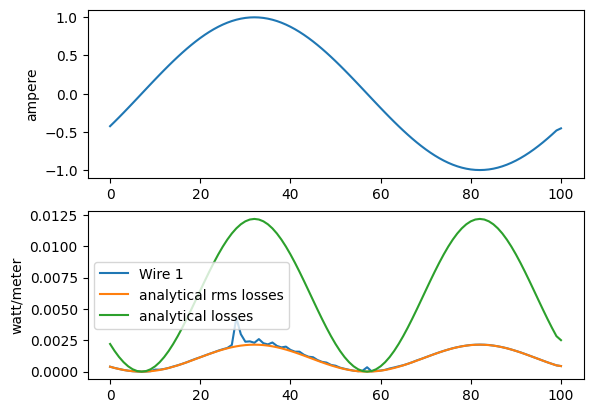

In [20]:

fig = plt.figure()
ax1 = fig.add_subplot(211)
ax1.plot(wire_currrent[:,0], label='Wire 1')

ax2 = fig.add_subplot(212)
ax2.plot(wire_joule_heating[:,0], label='Wire 1')
ax2.plot(wire_currrent[:,0]**2 * resistance , label='analytical rms losses')
ax2.plot(wire_currrent[:,0]**2 * resistance * f_skin, label='analytical losses')
ax2.legend()

In [21]:
f_skin

np.float64(5.663615734392911)

In [22]:
np.sqrt(np.mean(wire_current_density**2, axis=0))

Magnitude,[0.0 79060.45072642218 71691.11163638956 69194.136289687 65553.83666764456 63730.96372503423 60665.696822500744 59804.91898614907 57948.352027654066 56933.131648707065 56273.51851074406 56025.7025202083 56296.221005929394 56425.6602888509 56195.10589285428 56191.556798743 56510.088835084825 56755.89219413805 55426.193695335336 54264.2497239754 53578.45022097298 52587.300623790325 51911.82713299983 51060.87838944558 50508.84714471167 49870.30805775602 49416.06850177923 49159.07676414325 48694.26909563199 48391.00554902773 48063.792666306814 47903.338842502904 47768.40699340638 47702.54721284497 47678.80004857024 47663.554017748735 47677.168268514964 47703.35240794788 47778.03181913559 47849.520346991136 47887.54044266475 47950.59381247889 48028.068988078 48086.75703773291 48133.25149427492 48210.86325837073 48248.57806799926 48275.49440639423 48299.02443451397 48317.204289187735 48322.08324904459 48317.039664353935 48302.64502900323 48263.37083002775 48233.91575480962 48193.07877548434 48133.69222212973 48100.57390974497 48029.82687730414 47969.77485080162 47872.38354610373 47824.99967141263 47774.02061550972 47725.818672529174 47709.337823423615 47697.369361350764 47712.710238753505 47736.62304255307 47887.18183531149 48024.627745648475 48263.533450546354 48413.728827522464 48781.60088259009 49146.76732253952 49405.433798412356 50284.894268544354 50808.01088437384 51517.592976896114 51885.79952849788 52722.22620043313 53432.413693115246 54372.55840146874 55895.756055433485 57099.40874648776 56526.745551034954 56510.53894304799 56235.78673872873 56860.146385174565 56790.99316907188 55749.392103992475 56045.86623839529 57008.00216980416 57919.76068579275 59594.077524184686 60257.57035845968 63297.76076159537 65245.05161971625 68978.43664043592 71103.87338001558 77922.97847302537 0.0]
Units,ampere/meter2


In [23]:
np.sqrt(np.mean(wire_current_density**2, axis=0))

Magnitude,[0.0 79060.45072642218 71691.11163638956 69194.136289687 65553.83666764456 63730.96372503423 60665.696822500744 59804.91898614907 57948.352027654066 56933.131648707065 56273.51851074406 56025.7025202083 56296.221005929394 56425.6602888509 56195.10589285428 56191.556798743 56510.088835084825 56755.89219413805 55426.193695335336 54264.2497239754 53578.45022097298 52587.300623790325 51911.82713299983 51060.87838944558 50508.84714471167 49870.30805775602 49416.06850177923 49159.07676414325 48694.26909563199 48391.00554902773 48063.792666306814 47903.338842502904 47768.40699340638 47702.54721284497 47678.80004857024 47663.554017748735 47677.168268514964 47703.35240794788 47778.03181913559 47849.520346991136 47887.54044266475 47950.59381247889 48028.068988078 48086.75703773291 48133.25149427492 48210.86325837073 48248.57806799926 48275.49440639423 48299.02443451397 48317.204289187735 48322.08324904459 48317.039664353935 48302.64502900323 48263.37083002775 48233.91575480962 48193.07877548434 48133.69222212973 48100.57390974497 48029.82687730414 47969.77485080162 47872.38354610373 47824.99967141263 47774.02061550972 47725.818672529174 47709.337823423615 47697.369361350764 47712.710238753505 47736.62304255307 47887.18183531149 48024.627745648475 48263.533450546354 48413.728827522464 48781.60088259009 49146.76732253952 49405.433798412356 50284.894268544354 50808.01088437384 51517.592976896114 51885.79952849788 52722.22620043313 53432.413693115246 54372.55840146874 55895.756055433485 57099.40874648776 56526.745551034954 56510.53894304799 56235.78673872873 56860.146385174565 56790.99316907188 55749.392103992475 56045.86623839529 57008.00216980416 57919.76068579275 59594.077524184686 60257.57035845968 63297.76076159537 65245.05161971625 68978.43664043592 71103.87338001558 77922.97847302537 0.0]
Units,ampere/meter2


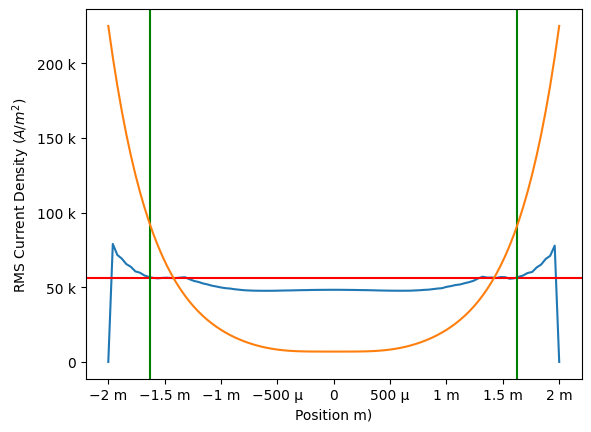

In [24]:

fig = plt.figure()
ax = fig.add_subplot(111)
#use the enginering tick formatter

ax.yaxis.set_major_formatter(EngFormatter())
ax.xaxis.set_major_formatter(EngFormatter())
ax.plot(wire_positions, np.sqrt(np.mean(wire_current_density**2, axis=0)))
ax.set_xlabel('Position m)')
ax.set_ylabel('RMS Current Density ($A/m^2$)')
rms_dc_current_density = np.sqrt(np.mean(wire_currrent**2, axis=0)) / (np.pi * (diameter/2)**2)
ax.axhline(rms_dc_current_density[0], color='red', label='Wire 1 RMS')
ax.axvline(-diameter/2+delta, color='green', label='Skin Depth')
ax.axvline(diameter/2-delta, color='green', label='Skin Depth')
ax.plot(wire_positions, np.abs(j), label='Analytical')

In [25]:
rms_dc_current_density

Magnitude,[56105.791902616314 0.0]
Units,ampere/meter2
